In [1]:
import numpy as np
import math
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.special import gamma, factorial
from scipy.stats import beta
import time

In [2]:
class PowerDiagram1D:
    def __init__(self, X, weights=None, L=1.0):
        """
        Parameters
        ----------
        X : ndarray,
            positions of particles (assumed ordered with no repeats)
        weights : ndarray, optional,
            weights of Laguerre cells
        L : float, optional,
            domain length
        """
        # use deep copy to make it independent, trivially slower, same for following copies
        self.X = np.array(X, copy=True)
        # store len(X) to avoid repeated reading
        self.n = len(X) 
        # check None in int to avoid checking everytime calling update_boundaries
        self.weights = np.zeros(self.n) if weights is None else np.array(weights, copy=True) 
        self.L = L
        self.Bounds = np.empty(self.n)
        self.indices = []
        self.updated_flag = False

    def set_positions(self, X):
        self.X = np.array(X, copy=True)

    def set_weights(self, weights):
        self.weights = np.array(weights, copy=True)
        self.updated_flag = False

    def update_boundaries(self):
        """
        Compute power diagram boundaries via Graham scan.
        """
        indices = [0, 1]
        u = (self.X**2 - self.weights) / 2

        # same function, but more readable and easier to debug
        def slope(i, j):
            return (u[j] - u[i]) / (self.X[j] - self.X[i])

        # same thing, but simpler, cleaner
        for i in range(2, self.n):
            while len(indices) >= 2 and slope(i, indices[-1]) <= slope(indices[-1], indices[-2]):
                indices.pop()
            indices.append(i)

        Bounds_noconstr = (u[indices][1:] - u[indices][:-1]) / (self.X[indices][1:] - self.X[indices][:-1])

        # Just not use mask (I do not get the point of creating mask here).
        i0 = np.sum(Bounds_noconstr <= 0)
        iend = np.sum(Bounds_noconstr >= self.L)
        indices = indices[i0:len(indices) - iend]

        self.indices = indices
        self.Bounds = np.zeros(len(indices) + 1)
        self.Bounds[-1] = self.L
        self.Bounds[1:-1] = Bounds_noconstr[i0:len(Bounds_noconstr) - iend] #(u[indices][1:] -u[indices][:-1])/(self.X[indices][1:] - self.X[indices][:-1])

        self.updated_flag = True

    def compute_energy(self, fun=None):
        """
        Computes power diagram energy sum_i int_{L_i} |x-x_i|^2
        """
        fplus = (self.Bounds[1:] - self.X[self.indices])**3/3
        fminus = (self.Bounds[:-1] - self.X[self.indices])**3/3
        return np.sum(fplus - fminus) # return directly

    def compute_integrals(self, fun):
        """
        Compute integral of function rho over Laguerre cells.
        Parameters:
        ----------
        fun: function. Density to integrate
        """
        if not self.updated_flag:
            self.update_boundaries()
        N = len(self.Bounds) - 1
        integrals = np.zeros(N)
        for i in range(N):
            integrals[i], _ = quad(fun, self.Bounds[i], self.Bounds[i + 1])
        return integrals

    def compute_integrals_ipp(self, intp_fun, p=None):
        """
        Computes the integral of fun(x)*(x-x_i)^p over Laguerre cells using integration by parts.
        Parameters:
        ----------
        intp_rho : list of length p+1, of lambda functions providing [int fun, int int fun , ..]
        """
        if p is None:
            p = len(intp_fun)-1
        else:
            assert len(intp_fun)>=p+1

        if p == 0:
            return intp_fun[0](self.Bounds[1:])-intp_fun[0](self.Bounds[:-1])
        # No need for else here
        integrals_p = ((self.Bounds[1:] - self.X[self.indices])**p*intp_fun[0](self.Bounds[1:])
                       - (self.Bounds[:-1] - self.X[self.indices])**p*intp_fun[0](self.Bounds[:-1]))
        integrals = -p * self.compute_integrals_ipp(intp_fun[1:], p=p-1) + integrals_p
        return integrals

    def compute_integrals_gradient(self, fun):
        """
        Compute gradient with respect to weights of 
            G: w --> integrals of function rho over Laguerre cells.
        """
        if not self.updated_flag:
            self.update_boundaries()
        # Force lower bound on density
        # temporary use, copy unnecessary
        Xact = self.X[self.indices]
        feval = fun(self.Bounds[1:-1])
        # fmin = np.min(feval) # unused object
        feval = feval * (1 - 1e-2) + 1e-2 #- fmin +   np.max((1e-2,fmin))
        
        #(np.maximum(fun(self.Bounds[1:-1])-fmin,0)+fmin)
        vect = 0.5 * feval/np.abs(Xact[1:] - Xact[:-1])
        vect0 = vect.copy()
        vect0[0] = 0
        costhess = diags(vect, -1) + diags(vect0, 1)
        vect1 = np.array(costhess.sum(axis=1)).flatten()

        # First row is zero apart from first element
        vect1[0] = -1
        costhess -= diags(vect1)

        return -costhess

In [3]:
class OptimalTransport1D(PowerDiagram1D):
    def __init__(self, X, masses, rho, intp_rho=None, L=1.0):
        super().__init__(X, L=L)
        self.masses = np.array(masses, copy=True)
        self.rho = rho
        self.intp_rho = intp_rho  # list of integrals of rho
        
    def compute_ot_cost(self):
        """
        Compute the optimal transport cost using direct quadrature.
        """
        N = len(self.Bounds) - 1
        integrals = np.zeros(N)
        for i in range(N):
            fun = lambda x: ((x - self.X[self.indices][i])**2 - self.weights[self.indices][i]) * self.rho(x)
            integrals[i], _ = quad(fun, self.Bounds[i], self.Bounds[i + 1]) # same, more readable
        return np.sum(integrals) + np.sum(self.masses * self.weights)

    def compute_ot_cost_ipp(self):
        """
        Compute the optimal transport cost using integration by parts.
        """
        # Modified to make it cleaner, more readable, and easier to debug
        term1 = np.sum(self.compute_integrals_ipp(self.intp_rho, p=2))
        term2 = np.sum(self.compute_integrals_ipp(self.intp_rho, p=0) * self.weights[self.indices])
        return np.sum(self.masses * self.weights) + (term1 - term2)

    def update_weights(self, tol=1e-6, maxIter=5e2, verbose=False):
        """
        Computes optimal weights with damped Newton
        """
        # Armijo parameter
        alphaA = 0.01
        tau_init = 0.5
        # New maximum number of update_boundaries() per step; used in the linesearch later
        max_line_search_trials = 3 
    
        self.update_boundaries()
    
        F = -self.masses.copy()
        if self.intp_rho is None:
            F[self.indices] += self.compute_integrals(self.rho)
            cost_old = self.compute_ot_cost()
        else:
            F[self.indices] += self.compute_integrals_ipp(self.intp_rho, p=0)
            cost_old = self.compute_ot_cost_ipp()
    
        error = np.linalg.norm(F)
        i = 0
    
        while error > tol and i < maxIter:
            Hess = self.compute_integrals_gradient(self.rho)
    
            theta = 0.0
            deltaw = -theta * F
            deltaw[self.indices] -= (1 - theta) * spsolve(Hess, F[self.indices])
    
            weights_old = self.weights.copy()
            tau = tau_init
            trial = 0
    
            """
            Smarter line search:
            Do not call update_boundaries() endlessly (3 times max), 
            where update_boundaries() has complexity of O(n)
            """
            while trial < max_line_search_trials:
                self.weights = weights_old + tau * deltaw
                self.update_boundaries()
    
                if self.intp_rho is None:
                    cost = self.compute_ot_cost()
                else:
                    cost = self.compute_ot_cost_ipp()
    
                # Armijo condition
                if (cost >= cost_old + tau * alphaA * np.dot(F, deltaw)
                        and len(self.indices) == len(self.X)):
                    break
                else:
                    tau *= 0.8
                    trial += 1
    
            # (If after 3 trials we still haven't satisfied Armijo, accept the last tau anyway)
    
            cost_old = cost
            i += 1
    
            # Update F and error
            F = -self.masses.copy()
            if self.intp_rho is None:
                F[self.indices] += self.compute_integrals(self.rho)
            else:
                F[self.indices] += self.compute_integrals_ipp(self.intp_rho, p=0)
    
            error = np.linalg.norm(F)
    
            if verbose:
                print(f"Newton step {i}, cost: {cost:.6f}, tau: {tau:.2e}, error: {error:.2e}")
    
            tau_init = min(tau * 1.1, 1.0)
    
        if i < maxIter and verbose:
            print("Optimization success!")

In [4]:
import numpy as np
from scipy.stats import beta

# --- Params ---
N = 300
n_noise = 3
n_signal = N - 4 * n_noise
np.random.seed(0)

# --- Build 2D data (unsorted), Beta(2,2) signal + four-corner noise ---
signal = np.column_stack((
    beta.rvs(2, 2, size=n_signal),
    beta.rvs(2, 2, size=n_signal)
))
c00 = np.column_stack((beta.rvs(1,100,size=n_noise), beta.rvs(1,100,size=n_noise)))
c01 = np.column_stack((beta.rvs(1,100,size=n_noise), beta.rvs(100,1,size=n_noise)))
c10 = np.column_stack((beta.rvs(100,1,size=n_noise), beta.rvs(1,100,size=n_noise)))
c11 = np.column_stack((beta.rvs(100,1,size=n_noise), beta.rvs(100,1,size=n_noise)))

XY = np.vstack([c00, c01, signal, c10, c11])  # (N, 2)  ← raw pairing kept
X  = XY[:, 0].copy()
Y  = XY[:, 1].copy()

# --- Prepare marginals for 1D training: sort separately & keep permutations ---
X_order   = np.argsort(X)       # indices that sort X
Y_order   = np.argsort(Y)       # indices that sort Y
X_sorted  = X[X_order]          # feed to wcETEL (x-axis)
Y_sorted  = Y[Y_order]          # feed to wcETEL (y-axis)

# Inverse permutations (to map sorted weights back to raw XY order later)
X_inv = np.empty_like(X_order); X_inv[X_order] = np.arange(N)
Y_inv = np.empty_like(Y_order); Y_inv[Y_order] = np.arange(N)

# Notes for later (after you have weights):
# wX_raw = np.empty(N); wX_raw[X_order] = wX_sorted   # map back to raw XY index
# wY_raw = np.empty(N); wY_raw[Y_order] = wY_sorted


In [5]:
L = 1.
masses = np.ones(N) / N

## Centering distribution is Beta(2,2)
rho0 = lambda x: 6*x*(1-x)

mass = 1.
masses = masses*mass

eta = 1e-3 # learning rate
n = len(X_sorted)
maxiter = 3000

## Run the fixed point iteration 80 times
for i in range(maxiter): 
    # solve optimal transport
    ot = OptimalTransport1D(X_sorted,masses,rho0, L=L)
    ot.update_weights(maxIter=1,verbose =False)
    ww=ot.weights

    # update masses
    masses1 = masses + eta*(-1-np.log(n*masses) - 2*5*ww)

    # projection back to simplex
    temp = np.max(np.where((masses1 + 1/(np.arange(1, len(masses1) + 1))*(1 - np.cumsum(masses1)) > 0))) + 1
    right_shift = (1/temp)*(1-np.cumsum(masses1)[temp-1])
    masses1 = masses1 + right_shift
    masses1[masses1 < 0] = 0

    # convergence check
    err = np.sum((masses-masses1)**2)
    if err <= 1e-20: 
      break
        
    ## print iteration
    print(i)
    ## track error
    print(err)
    masses = masses1

masses_x = masses1

0
7.719751902833625e-08
1
3.279787079275249e-08
2
1.3912108836989369e-08
3
5.901412145928732e-09
4
2.5059370843402493e-09
5
1.0657897497157235e-09
6
4.541143357092728e-10
7
1.9385553102236927e-10
8
8.290787722512471e-11
9
3.552099152927863e-11
10
1.5244358625304837e-11
11
6.5529265733357155e-12
12
2.8212345838068602e-12
13
1.2164851662255373e-12
14
5.253332660827063e-13
15
2.2721170815287813e-13
16
9.842633675062573e-14
17
4.270737046323449e-14
18
1.8562625045965662e-14
19
8.082808365365972e-15
20
3.5262975760674307e-15
21
1.5415658929683482e-15
22
6.753806054201128e-16
23
2.9657772780808075e-16
24
1.3055519467990206e-16
25
5.762071468809947e-17
26
2.5500866370874944e-17
27
1.1318385450521832e-17
28
5.0387859638906536e-18
29
2.2502654672771038e-18
30
1.0082242318587155e-18
31
4.532507965784388e-19
32
2.044621554475761e-19
33
9.255639917467687e-20
34
4.2047101266040906e-20
35
1.9169419246866722e-20


Final error after loop: 8.77e-21


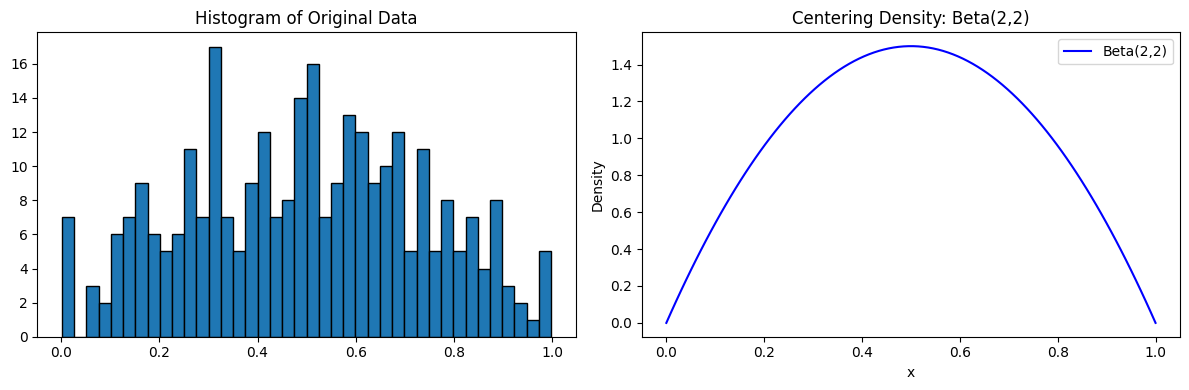

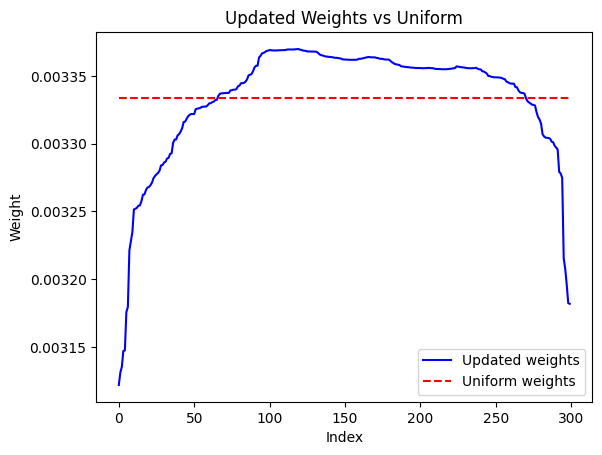

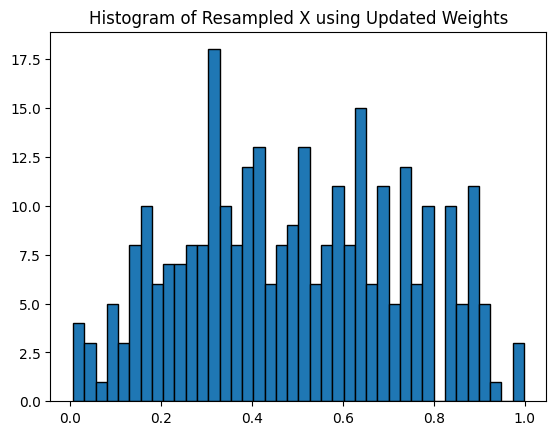

In [6]:
# check final error for comparison
print(f"Final error after loop: {err:.2e}")

x=ot.weights

# Assuming X and masses1 (updated weights) are already defined
N = len(X_sorted)
# 1. Histogram of original data
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(X_sorted, bins=40, edgecolor='black')
plt.title("Histogram of Original Data")

# 2. Plot centering density Beta(2, 2)
grid = np.linspace(0, 1, 100)
plt.subplot(1, 2, 2)
plt.plot(grid, beta.pdf(grid, 2, 2), label='Beta(2,2)', color='blue')
plt.title("Centering Density: Beta(2,2)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Plot updated weights vs uniform weights
plt.figure()
plt.plot(masses1, label='Updated weights', color='blue')
plt.plot(np.ones(N)/N, label='Uniform weights', color='red', linestyle='--')
plt.title("Updated Weights vs Uniform")
plt.xlabel("Index")
plt.ylabel("Weight")
plt.legend()
plt.show()

# 4. Resample X using updated weights
X_tilde = np.random.choice(X_sorted, size=N, p=masses1, replace=True)
# Plot histogram of resampled data
plt.hist(X_tilde, bins=40, edgecolor='black')
plt.title("Histogram of Resampled X using Updated Weights")
plt.show()

In [7]:
L = 1.
masses = np.ones(N) / N

## Centering distribution is Beta(2,2)
rho0 = lambda x: 6*x*(1-x)

mass = 1.
masses = masses*mass

eta = 1e-3 # learning rate
n = len(Y_sorted)
maxiter = 3000

## Run the fixed point iteration 80 times
for i in range(maxiter): 
    # solve optimal transport
    ot = OptimalTransport1D(Y_sorted,masses,rho0, L=L)
    ot.update_weights(maxIter=1,verbose =False)
    ww=ot.weights

    # update masses
    masses1 = masses + eta*(-1-np.log(n*masses) - 2*5*ww)

    # projection back to simplex
    temp = np.max(np.where((masses1 + 1/(np.arange(1, len(masses1) + 1))*(1 - np.cumsum(masses1)) > 0))) + 1
    right_shift = (1/temp)*(1-np.cumsum(masses1)[temp-1])
    masses1 = masses1 + right_shift
    masses1[masses1 < 0] = 0

    # convergence check
    err = np.sum((masses-masses1)**2)
    if err <= 1e-20: 
      break
        
    ## print iteration
    print(i)
    ## track error
    print(err)
    masses = masses1

masses_y = masses1

0
3.42786523158555e-07
1
1.2584305432794832e-07
2
4.658785149262041e-08
3
1.7444004848308515e-08
4
6.623964662627329e-09
5
2.5563306338683165e-09
6
1.0040989946866272e-09
7
4.017051627127591e-10
8
1.6368129987607917e-10
9
6.788140649958287e-11
10
2.8617439068170632e-11
11
1.2244780110727896e-11
12
5.308177836249512e-12
13
2.3272220874630166e-12
14
1.0301302358205979e-12
15
4.596685297795414e-13
16
2.0649994533235978e-13
17
9.328950105667523e-14
18
4.2343276125584475e-14
19
1.9295367677434146e-14
20
8.822315020071544e-15
21
4.045496962190631e-15
22
1.8597935228411208e-15
23
8.569210237900432e-16
24
3.956473742342427e-16
25
1.8301969287410695e-16
26
8.481203967775992e-17
27
3.936851239798718e-17
28
1.830393315531676e-17
29
8.523615957865597e-18
30
3.975333506536183e-18
31
1.8568820042075557e-18
32
8.686609852025595e-19
33
4.0697552189774224e-19
34
1.9095750098301567e-19
35
8.973362944144648e-20
36
4.223030590915045e-20
37
1.9904185575897038e-20


Final error after loop: 9.40e-21


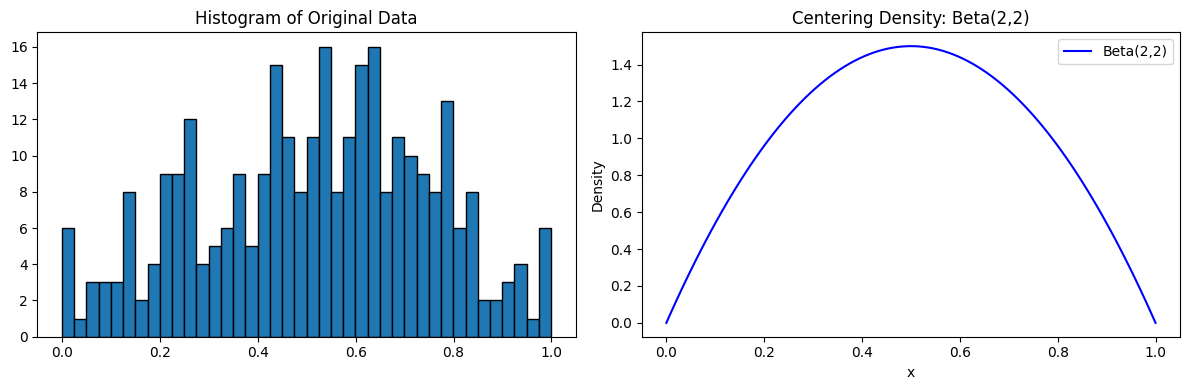

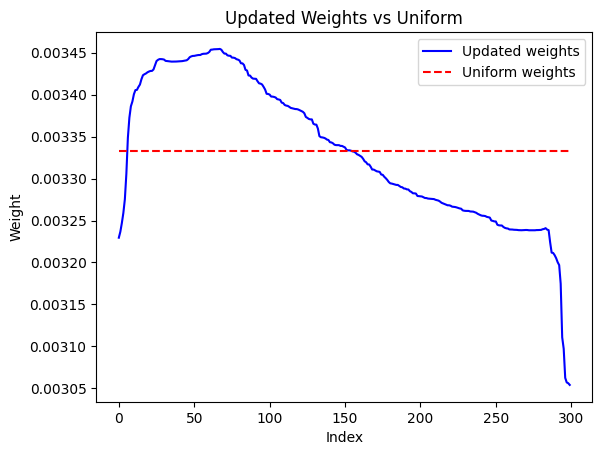

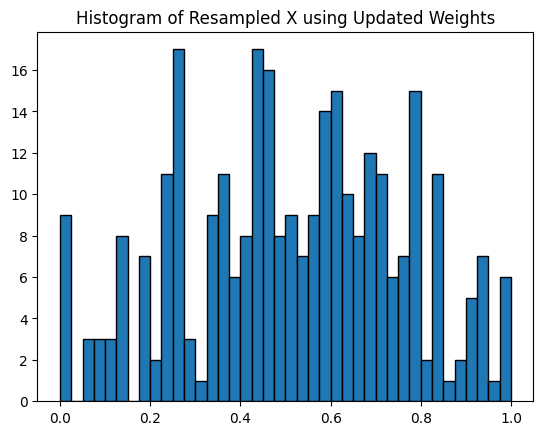

In [8]:
# check final error for comparison
print(f"Final error after loop: {err:.2e}")

y=ot.weights

# Assuming X and masses1 (updated weights) are already defined
N = len(Y_sorted)
# 1. Histogram of original data
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(Y_sorted, bins=40, edgecolor='black')
plt.title("Histogram of Original Data")

# 2. Plot centering density Beta(2, 2)
grid = np.linspace(0, 1, 100)
plt.subplot(1, 2, 2)
plt.plot(grid, beta.pdf(grid, 2, 2), label='Beta(2,2)', color='blue')
plt.title("Centering Density: Beta(2,2)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# 3. Plot updated weights vs uniform weights
plt.figure()
plt.plot(masses1, label='Updated weights', color='blue')
plt.plot(np.ones(N)/N, label='Uniform weights', color='red', linestyle='--')
plt.title("Updated Weights vs Uniform")
plt.xlabel("Index")
plt.ylabel("Weight")
plt.legend()
plt.show()

# 4. Resample X using updated weights
Y_tilde = np.random.choice(Y_sorted, size=N, p=masses1, replace=True)
# Plot histogram of resampled data
plt.hist(Y_tilde, bins=40, edgecolor='black')
plt.title("Histogram of Resampled X using Updated Weights")
plt.show()

In [9]:
import numpy as np

def _to_prob(v):
    v = np.asarray(v, dtype=float)
    # If they aren't valid weights, turn scores into probs via softmax
    if (v < 0).any() or not np.isclose(v.sum(), 1.0, rtol=1e-3, atol=1e-6):
        v = np.exp(v - v.max())
    s = v.sum()
    return v / s if s > 0 else np.full_like(v, 1.0/len(v))

def map_back(sorted_w, inv_perm):
    raw = np.empty_like(sorted_w, dtype=float)
    raw[inv_perm] = sorted_w
    return raw

# Map sorted weights back to raw XY order
wX_raw = map_back(masses_x, X_inv)
wY_raw = map_back(masses_y, Y_inv)

# Ensure proper probability vectors
wX_raw = _to_prob(wX_raw)
wY_raw = _to_prob(wY_raw)

# Independence combine → 2D per-sample weights aligned with original pairs
w2d = wX_raw * wY_raw
w2d /= w2d.sum()

print(f"sum(wX_raw)={wX_raw.sum():.6f}, sum(wY_raw)={wY_raw.sum():.6f}, sum(w2d)={w2d.sum():.6f}")


sum(wX_raw)=1.000000, sum(wY_raw)=1.000000, sum(w2d)=1.000000


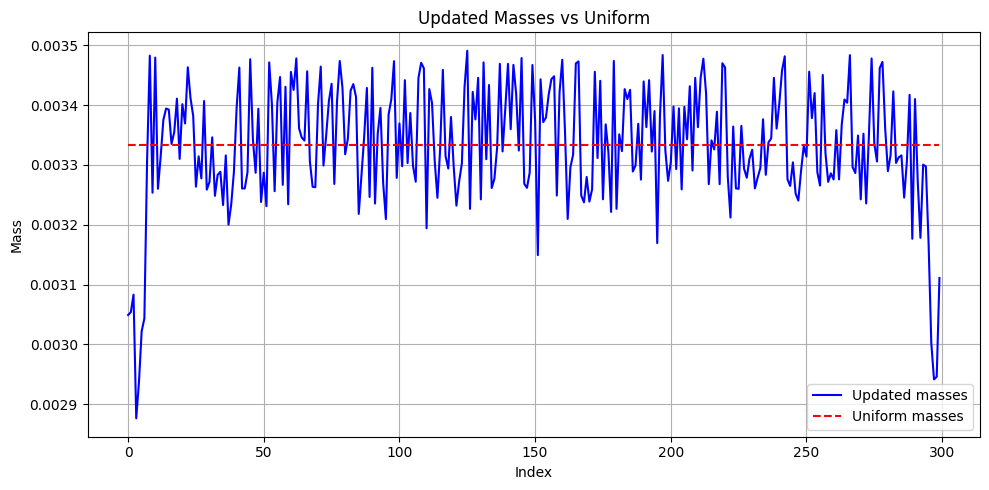

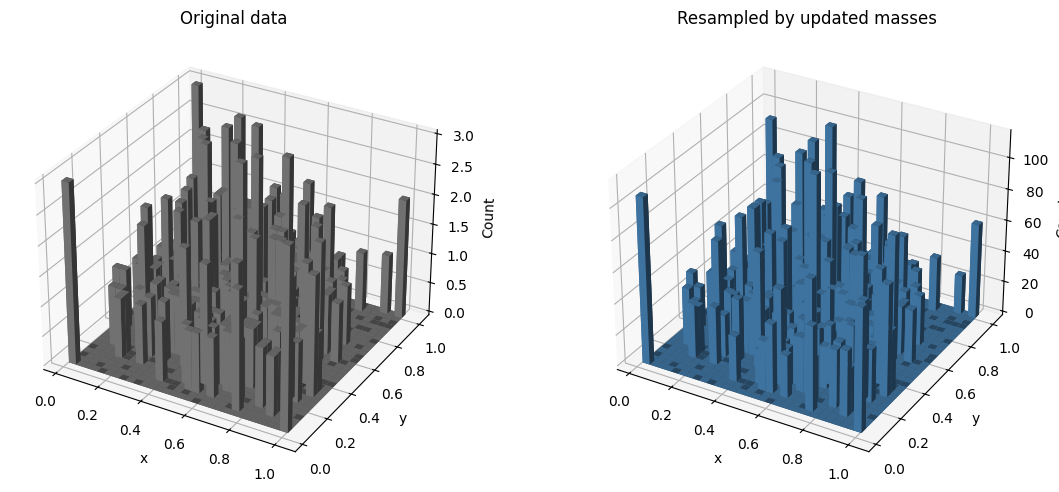

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# assume:
#   XY   = (N,2) data array
#   w2d  = combined weights aligned with XY

# ensure weights are probabilities
w = np.asarray(w2d, dtype=float).copy()
w = np.maximum(w, 0)
w_sum = w.sum()
w = w / w_sum if w_sum > 0 else np.full_like(w, 1.0/len(w))
N = len(w)

# 1. Updated masses vs uniform
plt.figure(figsize=(10,5))
plt.plot(w, label="Updated masses", color="blue")
plt.plot(np.ones_like(w)/N, color="red", linestyle="--", label="Uniform masses")
plt.title("Updated Masses vs Uniform")
plt.xlabel("Index"); plt.ylabel("Mass")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# 2. 3D histograms: original vs resampled
bins = 30
num_resample = 10000

# original histogram
H1, xedges, yedges = np.histogram2d(XY[:,0], XY[:,1], bins=bins, range=[[0,1],[0,1]])
xc = xedges[:-1] + 0.5*(xedges[1]-xedges[0])
yc = yedges[:-1] + 0.5*(yedges[1]-yedges[0])
xpos, ypos = np.meshgrid(xc, yc, indexing="ij")
xpos = xpos.ravel(); ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dz1 = H1.ravel()

# resample according to weights
idx = np.random.choice(len(XY), size=num_resample, p=w)
resampled = XY[idx]
H2, _, _ = np.histogram2d(resampled[:,0], resampled[:,1], bins=[xedges, yedges])
dz2 = H2.ravel()

fig = plt.figure(figsize=(12,5))

ax0 = fig.add_subplot(1,2,1, projection="3d")
ax0.bar3d(xpos, ypos, zpos, dx=1/bins, dy=1/bins, dz=dz1, color="gray", zsort="average")
ax0.set_title("Original data")
ax0.set_xlabel("x"); ax0.set_ylabel("y"); ax0.set_zlabel("Count")

ax1 = fig.add_subplot(1,2,2, projection="3d")
ax1.bar3d(xpos, ypos, zpos, dx=1/bins, dy=1/bins, dz=dz2, color="steelblue", zsort="average")
ax1.set_title("Resampled by updated masses")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("Count")

plt.tight_layout(); plt.show()
